# Purpose

This notebook is going to record my notes on clustering my simulated single cell genomics data in a cleaner format. The previous clustering notes got too big so I'm going to transfer the relevant info onto this notebook.

In [1]:
#import modules
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

In [2]:
df = pd.read_csv('/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/test_DATA_simV2_crossovers.tsv', sep='\t', header=None)

In [3]:
true_labels = df.values[:,0]

In [4]:
E0 = []
for i in [2, 5, 8, 11, 14]:
    arr = np.asarray(df[i].isnull())
    if len(E0) == 0:
        E0 = arr
    else:
        E0 = np.vstack((E0, arr))
E0_index = np.where(np.sum(E0.astype(int), axis=0) == 5 )


In [3]:
#Load data
data = np.load('/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/SPARSE_7-19_test_set_HMM_posteriors.npy')

In [4]:
PCA_data = PCA(n_components=50).fit(data)

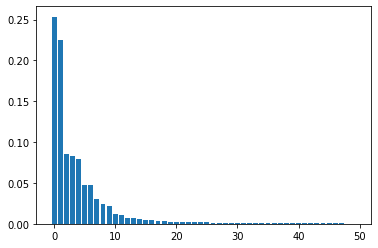

In [11]:
plt.bar([i for i in range(50)], PCA_data.explained_variance_ratio_)
plt.show()

In [16]:
np.sum(PCA_data.explained_variance_ratio_[0:11])

0.9101013514765531

In [6]:
#Dimension reduction let's just create an array with all of the parameters I want to play with here:
PCA_data = PCA(n_components=50).fit_transform(data)
pca_tsne = []
tsne = []
for i in [10, 25, 50, 100]:
    tsne_PCA = TSNE(early_exaggeration=len(data)/3, perplexity=i, n_components=2, init='pca').fit_transform(PCA_data)
    tsne_embedding = TSNE(early_exaggeration=len(data)/3, perplexity=i, n_components=2, init='pca').fit_transform(data)
    pca_tsne.append(tsne_PCA)
    tsne.append(tsne_embedding)

KeyboardInterrupt: 

To further establish some more robust benchmarking I am plotting out the result of the clustering metrics given several of these perplexity iterations under PCA dimension reduction and without PCA. Also I am trying a small range of eps values.

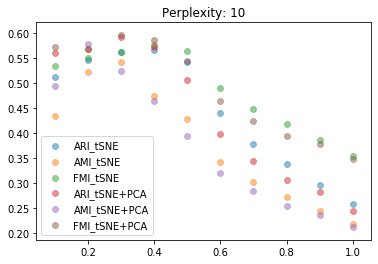

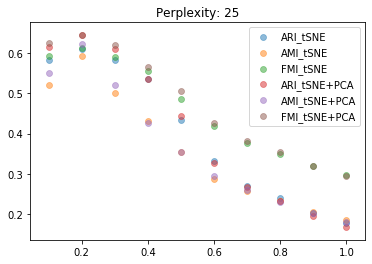

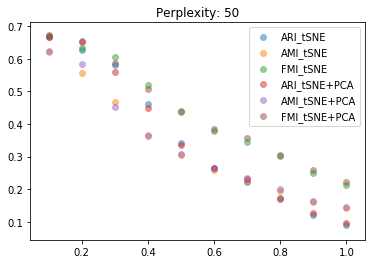

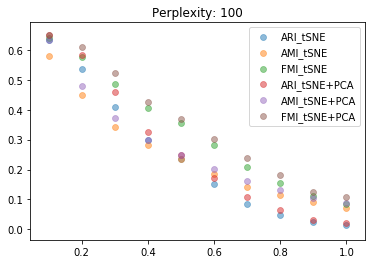

In [42]:
all_embeds = [tsne, pca_tsne]
for i in range(4): #Iterate through each embedding at our perplexity values
    #Cluster the data
    ari_vect = np.zeros(shape=(2,10))
    ami_vect = np.zeros(shape=(2,10))
    fmi_vect = np.zeros(shape=(2,10))
    epsilon = []
    for eps in range(1, 11): 
        E = eps/10
        index = eps - 1
        for embed in range(2):
            db_labels = DBSCAN(eps=E, min_samples=1).fit(all_embeds[embed][i]).labels_
            ARI = metrics.adjusted_rand_score(true_labels, db_labels)
            vmes = metrics.homogeneity_completeness_v_measure(true_labels, db_labels)
            with warnings.catch_warnings(): #Catch annoying future warnings
                warnings.filterwarnings("ignore")
                AMI = metrics.adjusted_mutual_info_score(true_labels, db_labels,)
            FMI = metrics.fowlkes_mallows_score(true_labels, db_labels)

            #add to vectors
            ari_vect[embed][index] = ARI
            ami_vect[embed][index] = AMI
            fmi_vect[embed][index] = FMI
            
        epsilon.append(E)
        
        #print('Perplexity: {0}'.format([10, 25, 50, 100][i]))
        #print('ARI: {0}\nHomogeneity: {1}\nCompleteness: {2}\nV-measure: {3}\nAMI: {4}\nFMI: {5}'.format(ARI, vmes[0], vmes[1], vmes[2], AMI, FMI))
    
    for emb in range(2):
        sns.scatterplot(epsilon, ari_vect[emb,:],edgecolor=None,alpha=.5, marker='.')
        sns.scatterplot(epsilon, ami_vect[emb,:],edgecolor=None, alpha=.5, marker='.')
        sns.scatterplot(epsilon, fmi_vect[emb,:],edgecolor=None, alpha=.5, marker='.')
        
    plt.legend(['ARI_tSNE', 'AMI_tSNE', 'FMI_tSNE', 'ARI_tSNE+PCA', 'AMI_tSNE+PCA', 'FMI_tSNE+PCA'])
    plt.title('Perplexity: {0}'.format([10, 25, 50, 100][i]))
    plt.show()
    plt.close()
    

### Results:

From these results 25, 50, and 100 seem to have similar peaks in quality. And it seems that PCA or no PCA seem to give similar results in quality and have similar optima. Perplexity 50 may be a better parameter choice for clustering this data and it may be just as good to reduce dimensions with PCA to 50 before inputting into tSNE.

Examining the embeddings further we see the following:

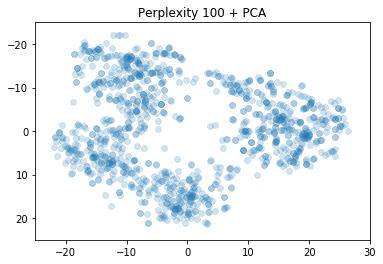

In [57]:
sns.scatterplot(pca_tsne[3][:,0], pca_tsne[3][:,1], alpha=.2, edgecolor=None)
plt.xlim([-25, 30])
plt.ylim([25, -25])
plt.title('Perplexity 100 + PCA')
plt.show()
plt.close()

After I zoom in on these data in the correct dimensions we actually see some interesting structure of the data when Perplexity is 100. There seems to be pretty good seperation of the data, but there are just like 2 points that fly off way, way off from the main cluster. 

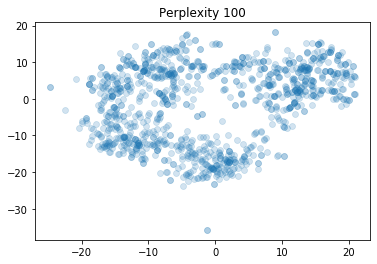

In [59]:
sns.scatterplot(tsne[3][:,0], tsne[3][:,1], alpha=.2, edgecolor=None)
#plt.xlim([-25, 30])
#plt.ylim([25, -25])
plt.title('Perplexity 100')
plt.show()
plt.close()

Without PCA the underlying structure looks similar, but would take less time to run. I am going to rerun the benchmarking on the 100 perplexity embeddings on lower epsilon values and see if the optima is actually further down.

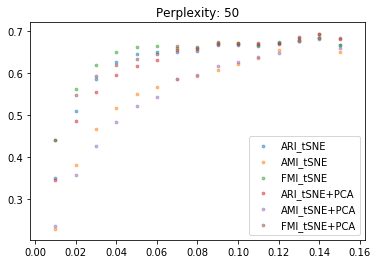

ValueError: arrays must all be same length

In [64]:
for i in [2, 3]:
    ari_vect = np.zeros(shape=(2,15))
    ami_vect = np.zeros(shape=(2,15))
    fmi_vect = np.zeros(shape=(2,15))
    epsilon = []

    for eps in range(1, 16): 
        E = eps/100
        index = eps - 1
        for embed in range(2):
            db_labels = DBSCAN(eps=E, min_samples=1).fit(all_embeds[embed][i]).labels_
            ARI = metrics.adjusted_rand_score(true_labels, db_labels)
            vmes = metrics.homogeneity_completeness_v_measure(true_labels, db_labels)
            with warnings.catch_warnings(): #Catch annoying future warnings
                warnings.filterwarnings("ignore")
                AMI = metrics.adjusted_mutual_info_score(true_labels, db_labels,)
            FMI = metrics.fowlkes_mallows_score(true_labels, db_labels)

                #add to vectors
            ari_vect[embed][index] = ARI
            ami_vect[embed][index] = AMI
            fmi_vect[embed][index] = FMI

        epsilon.append(E)

            #print('Perplexity: {0}'.format([10, 25, 50, 100][i]))
            #print('ARI: {0}\nHomogeneity: {1}\nCompleteness: {2}\nV-measure: {3}\nAMI: {4}\nFMI: {5}'.format(ARI, vmes[0], vmes[1], vmes[2], AMI, FMI))

    for emb in range(2):
        sns.scatterplot(epsilon, ari_vect[emb,:],edgecolor=None,alpha=.5, marker='.')
        sns.scatterplot(epsilon, ami_vect[emb,:],edgecolor=None, alpha=.5, marker='.')
        sns.scatterplot(epsilon, fmi_vect[emb,:],edgecolor=None, alpha=.5, marker='.')

    plt.legend(['ARI_tSNE', 'AMI_tSNE', 'FMI_tSNE', 'ARI_tSNE+PCA', 'AMI_tSNE+PCA', 'FMI_tSNE+PCA'])
    plt.title('Perplexity: {0}'.format([10, 25, 50, 100][i]))
    plt.show()
    plt.close()